# Organizing the Data

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

In [ ]:
%cd "/home/usr/Documents/reg-class-fault-detection/dataset/train_test_dataset_Fault Impact Analysis"

In [3]:
def getFrames(d):

    frames = []

    for name in d:
        if name.endswith('.csv'):
            df = pd.read_csv(name)
            frames.append(df)

    return frames

def label_func(faultD):
  if(faultD == 0):
    return 0
  elif(faultD < 500):
    return 1
  else:
    return 2

def bin_func(faultD):
  if(faultD == 0):
    return 0
  else:
    return (faultD//500 + 1)

def faultlabel(b):
  if(b == 0): return 0
  elif(b == 1): return 1
  else: return 2

In [5]:
csv_list = os.listdir()
all_frames = getFrames(csv_list)
print(len(all_frames))
df_complete = pd.concat(all_frames, ignore_index= True)
print("length of complete df: " + str(len(df_complete)))


7256
length of complete df: 908922


In [6]:
df_main = df_complete.copy()

fault_df = df_complete[df_complete['fault_duration'] > 0]
fault_df = fault_df[fault_df['relation'] > 0.98]

no_fault_df = df_main[df_main['relation'] == 0]

In [12]:
df_main = pd.concat([fault_df, no_fault_df])
df_main = df_main.sample(frac=1)
df_main = df_main.drop(columns=['NE ID','endTime', 'relation'])
df_main = df_main.dropna()
df_main['fault_label'] = df_main['fault_duration'].apply(label_func)
df_main['bin'] = df_main['fault_duration'].apply(bin_func)

In [13]:
X_df = df_main.copy()
X_df = X_df.drop(columns=['fault_duration', 'fault_label','bin'])

## Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

scalerMinMax = MinMaxScaler()
df_scaled = X_df.copy()


X_std  = scalerMinMax.fit_transform(df_scaled)
df_scaled[['access_success_rate', 'resource_utilition_rate', 'TA', 'bler', 'cqi',
       'mcs', 'data_rate']] = X_std


df_scaled['fault_duration'] = df_main['fault_duration']
df_scaled['fault_label'] = df_main['fault_label']
df_scaled['bin'] = df_main['bin']

df_scaled

,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,fault_label,bin
740675,0.999557,0.713249,0.190049,0.112108,0.538759,0.328982,0.015253,0.0,0,0.0
644766,0.999389,0.515667,0.212570,0.105572,0.455119,0.364273,0.008529,0.0,0,0.0
517603,1.000000,0.056542,0.142161,0.082371,0.700880,0.312109,0.099659,0.0,0,0.0
228873,0.995968,0.238538,0.273542,0.116376,0.425696,0.246480,0.007388,0.0,0,0.0
223983,0.979167,0.086619,0.279544,0.092310,0.332285,0.163319,0.008050,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
159356,1.000000,0.090813,0.215226,0.074054,0.640868,0.351496,0.105138,0.0,0,0.0
597645,1.000000,0.021430,0.248977,0.078248,0.701525,0.267067,0.058080,0.0,0,0.0
800724,0.999630,0.360800,0.173833,0.110148,0.531136,0.373947,0.058420,0.0,0,0.0
134207,1.000000,0.023652,0.196302,0.068698,0.603537,0.329425,0.049576,0.0,0,0.0


In [15]:
df_x2 = df_scaled.copy()
y_bin = df_x2['bin'].values
df_x2 = df_x2.drop(columns=['fault_label','bin'])
X_std2 = df_x2.values

## SMOTE

In [16]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto',random_state=15)

X_res, y_bin_res = sm.fit_resample(X_std2, y_bin)

In [18]:
y_label_res = [faultlabel(b) for b in y_bin_res ]
X_res_7d = np.delete(X_res, 7, axis=1)


In [19]:
df_labeled_res = pd.DataFrame()
df_labeled_res[['access_success_rate', 'resource_utilition_rate', 'TA', 'bler', 'cqi','mcs', 'data_rate','fault_duration']] = X_res
df_labeled_res['bin'] = y_bin_res
df_labeled_res['fault'] = y_label_res

df_labeled_res

,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,bin,fault
0,0.999557,0.713249,0.190049,0.112108,0.538759,0.328982,0.015253,0.0,0.0,0
1,0.999389,0.515667,0.212570,0.105572,0.455119,0.364273,0.008529,0.0,0.0,0
2,1.000000,0.056542,0.142161,0.082371,0.700880,0.312109,0.099659,0.0,0.0,0
3,0.995968,0.238538,0.273542,0.116376,0.425696,0.246480,0.007388,0.0,0.0,0
4,0.979167,0.086619,0.279544,0.092310,0.332285,0.163319,0.008050,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
7273210,0.971524,0.289288,0.497793,0.154321,0.336714,0.189303,0.006249,3600.0,8.0,2
7273211,1.000000,0.019454,0.108085,0.071574,0.800490,0.717675,0.000000,3600.0,8.0,2
7273212,0.992431,0.868727,0.531945,0.186700,0.446993,0.201127,0.005220,3600.0,8.0,2
7273213,0.998221,0.037882,0.387400,0.095672,0.433217,0.257015,0.009429,3600.0,8.0,2


In [20]:
df_labeled_res['fault_duration'].mean()

1746.2522308446678

In [21]:
df_0 = df_labeled_res[df_labeled_res['fault'] == 0]
df_1 = df_labeled_res[df_labeled_res['fault'] == 1]
df_2 = df_labeled_res[df_labeled_res['fault'] == 2]

df_2 = df_2.sample(frac= 0.2)

In [22]:
df_eq = pd.concat([df_0,df_1,df_2])
df_eq = df_eq.sample(frac=1)

In [24]:
fault_df_eq = df_eq[df_eq['fault'] != 0]
no_fault_df_eq = df_eq[df_eq['fault'] == 0]


In [25]:
df_fault = fault_df_eq.copy()

scalerMinMax.fit(df_fault.drop(columns=['fault_duration', 'bin','fault']).values, df_fault['fault'].values)
X_std  = scalerMinMax.inverse_transform(df_fault.drop(columns=['fault_duration', 'bin','fault']).values)

df_fault[['access_success_rate', 'resource_utilition_rate', 'TA', 'bler', 'cqi','mcs', 'data_rate']] = X_std


df_fault['fault_duration'] = df_fault['fault_duration']
df_fault['fault'] = df_fault['fault']
df_fault['bin'] = df_fault['bin']

df_fault

,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate,fault_duration,bin,fault
4535942,1.000000,0.054972,0.154576,0.083109,0.502720,0.265698,0.030741,2119.000000,5.0,2
6423628,0.000000,0.009409,0.000000,0.000000,0.000000,0.000000,0.000000,3483.785936,7.0,2
4859957,0.245761,0.024495,0.041625,0.022324,0.125266,0.059337,0.004731,2450.245761,5.0,2
4844459,0.999183,0.194685,0.253526,0.099492,0.658546,0.339172,0.033392,2136.000000,5.0,2
1273511,0.993627,0.578756,0.498345,0.183440,0.326668,0.105073,0.005994,388.000000,1.0,1
...,...,...,...,...,...,...,...,...,...,...
1498648,0.999323,0.207876,0.214422,0.114750,0.636968,0.316633,0.032314,420.000000,1.0,1
4636456,0.999474,0.100623,0.233782,0.098491,0.518525,0.247258,0.015349,2241.228361,5.0,2
1920965,1.000000,0.105160,0.493194,0.115937,0.408273,0.172839,0.011621,682.000000,2.0,2
905097,0.999909,0.534398,0.313590,0.118547,0.473503,0.285639,0.017821,91.000000,1.0,1


## construindo o dataset

In [26]:
len(fault_df_eq )

1939524

In [27]:
len(no_fault_df_eq) 

808135

In [28]:
ratio = len(no_fault_df_eq)/len(fault_df_eq)
faults = fault_df_eq.sample(frac=ratio)

In [29]:
labels = faults['fault']
faults = faults.drop(columns=['fault_duration', 'bin','fault'])
faults_v = faults.values

no_faults_v = no_fault_df_eq.drop(columns=['fault_duration', 'bin','fault']).values

print(f"FAULTS : {np.shape(faults_v)} NO FAULTS: {np.shape(no_faults_v)}")



FAULTS : (808135, 7) NO FAULTS: (808135, 7)


In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, f1_score, recall_score

def show_results(y_test, predictions):
  print('Accuracy score:', accuracy_score(y_test, predictions))
  print('f1 score:', f1_score(y_test, predictions))
  print('recall score:', recall_score(y_test, predictions))

  font = {'family' : 'serif', 'weight' : 'bold', 'size':18}
  plt.rc('font', **font)
  disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels=None)
  disp.plot()
  plt.show()



## GAN

In [2]:
import torch
import torch.nn as nn
from joblib import dump, load

In [3]:
kpi_df = pd.read_csv("/home/usr/Documents/reg-class-fault-detection/dataset/smenn_dataset.csv")

In [5]:
kpi_df = kpi_df.drop(columns=['Unnamed: 0'])

In [7]:
fault_df = kpi_df[kpi_df['fault'] > 0]

In [8]:
classifier = load('/home/usr/Documents/reg-class-fault-detection/dataset/models/smoteen trained models/xgb_075split_non-opt.joblib')

In [10]:
# Generator
class Generator(nn.Module):
    def __init__(self, input_shape):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, input_shape**2),
            nn.ReLU(),
            nn.Linear(input_shape**2, input_shape)
        )

    def forward(self, x):
        return self.model(x)


# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, input_shape**2),
            nn.ReLU(),
            nn.Linear(input_shape**2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        return self.model(x)


In [11]:
# Initialize the models and move them to the device
generator = Generator(fault_df.values.shape[1])
discriminator = Discriminator(fault_df.values.shape[1])

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.001)

In [12]:
data = fault_df.values

In [49]:
# Training the GAN
num_epochs = 5000
for epoch in range(num_epochs):
    # Train discriminator
    optimizer_d.zero_grad()

    real_data = torch.tensor(data,dtype=torch.float32)
    real_labels = torch.ones(len(data), 1, dtype=torch.float32)
    outputs = discriminator(real_data)
    d_loss_real = criterion(outputs, real_labels)

    # Generate fake data
    noise = torch.rand(size=(len(data), data.shape[1]))
    fake_data = generator(noise)
    fake_labels = torch.zeros(len(data), 1)
    outputs = discriminator(fake_data.detach())
    d_loss_fake = criterion(outputs, fake_labels)

    # Backprop and optimize
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    optimizer_d.step()

    # Train generator
    optimizer_g.zero_grad()
    outputs = discriminator(fake_data)
    g_loss = criterion(outputs, real_labels)
    g_loss.backward()
    optimizer_g.step()

    # Print losses
    if (epoch+1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

Epoch [1000/20000], d_loss: 1.2090, g_loss: 0.9810
Epoch [2000/20000], d_loss: 1.2812, g_loss: 0.7438
Epoch [3000/20000], d_loss: 1.4390, g_loss: 1.3611
Epoch [4000/20000], d_loss: 1.0816, g_loss: 0.9553


In [ ]:
with torch.no_grad():
    test_noise = torch.rand(size=(len(data), data.shape[1]))
    generated_data = generator(test_noise)


In [ ]:
np.shape(data)

(39864, 28)

In [ ]:
generated_data

tensor([[ 9.7167e-01,  1.9959e-03,  2.7522e-01,  ...,  1.1703e-01,
         -3.1404e-02,  5.2028e-01],
        [ 1.0164e+00, -3.6105e-03,  2.6272e-01,  ...,  5.8649e-02,
         -6.8749e-02,  5.2554e-01],
        [ 9.7898e-01, -2.4347e-03,  2.6891e-01,  ...,  9.9789e-02,
         -5.3593e-02,  5.2350e-01],
        ...,
        [ 1.0053e+00, -9.6552e-05,  2.6841e-01,  ...,  7.7848e-02,
         -4.9751e-02,  5.2280e-01],
        [ 1.0201e+00,  1.2727e-03,  2.6819e-01,  ...,  6.5582e-02,
         -4.7354e-02,  5.2237e-01],
        [ 9.9561e-01,  9.2520e-03,  2.8101e-01,  ...,  1.0828e-01,
         -4.4409e-03,  5.1619e-01]])

In [ ]:
predictions = classifier.predict(generated_data)
labels = [1 for line in generated_data]
show_results(labels, predictions)

ValueError: Feature shape mismatch, expected: 31, got 28

In [ ]:
def correlation(df, fontsize=10):

  font = {'family' : 'serif', 'weight' : 'bold', 'size':fontsize}
  plt.rc('font', **font)

  corr_matrix = df.corr()
  sn.heatmap(corr_matrix, annot=True)
  plt.show()

In [ ]:
# %cd "/home/usr/Documents/reg-class-fault-detection/dataset/models"
# torch.save(generator, 'GAN-FAULT-GENERATOR.pt')

/home/usr/Documents/reg-class-fault-detection/dataset/models


/home/usr/anaconda3/envs/cnn-env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
# with torch.no_grad():
#     test_noise = torch.rand(size=(len(data), 7))
#     generated_data = generator(test_noise)


In [ ]:
df_fake_data = pd.DataFrame()
df_fake_data[['access_success_rate','resource_utilition_rate',	'TA',	'bler','cqi','mcs','data_rate']] = generated_data

In [ ]:
df_fake_data

,access_success_rate,resource_utilition_rate,TA,bler,cqi,mcs,data_rate
0,0.579052,0.120539,-0.087093,0.216550,0.537700,0.057538,-0.019193
1,0.436442,0.094721,-0.297409,0.268563,0.501760,-0.084367,-0.057537
2,0.551934,0.103362,-0.160817,0.216389,0.520568,0.011999,-0.023098
3,0.540352,0.117929,-0.144303,0.225551,0.517738,0.026409,-0.026503
4,0.640090,0.139658,-0.027603,0.188407,0.538329,0.099395,-0.001889
...,...,...,...,...,...,...,...
38785,0.479390,0.104198,-0.240508,0.251659,0.509472,-0.045612,-0.045801
38786,0.477187,0.109172,-0.242968,0.251788,0.520413,-0.049249,-0.046862
38787,0.551801,0.120177,-0.144573,0.223158,0.522475,0.019728,-0.026014
38788,0.451867,0.098125,-0.276973,0.262492,0.504530,-0.070448,-0.053322


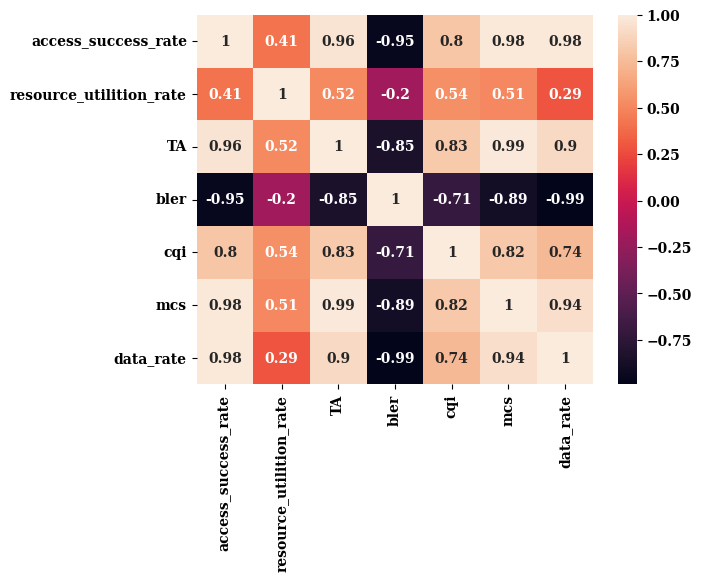

In [ ]:
correlation(df_fake_data)

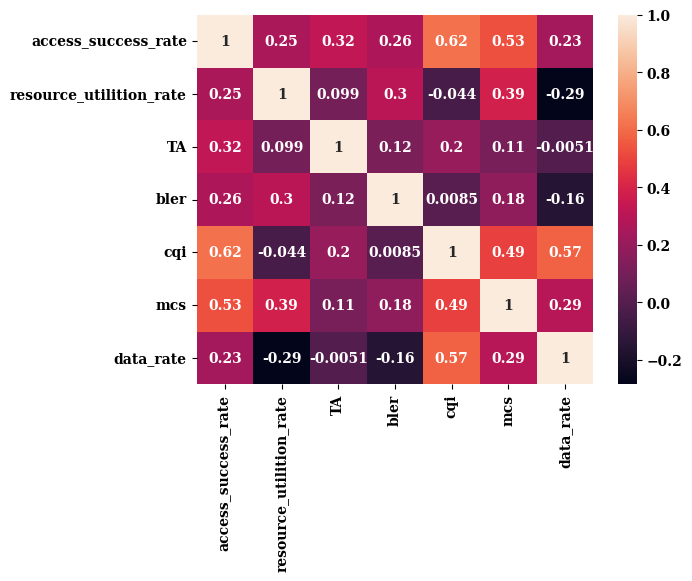

In [ ]:
correlation(df_fault.drop(columns=['fault_duration','bin','fault']).sample(frac=0.2))